<a href="https://colab.research.google.com/github/Ignas12345/Magistro_projektas/blob/main/knygutes/TCGA_genu_raisku_analize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Atsisiunčiam bibliotekas ir įsikeliam duomenis

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Install DESeq2 (if not already installed)
if (!requireNamespace("DESeq2", quietly = TRUE)) {
  BiocManager::install("DESeq2")
}

# Load the DESeq2 library
library(DESeq2)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'bit64', 'httr2', 'pkgbuild', 'rlang', 'systemfonts',
  'textshaping'

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

 

In [268]:
url = 'https://raw.githubusercontent.com/Ignas12345/Magistro_projektas/refs/heads/main/duomenys/filtered_gene_expression_counts.csv'
gene_expression_counts = read.csv(url)
head(gene_expression_counts)

,source,type,score,phase,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,⋯,TCGA.WZ.A7V3.01A.11R.A431.07,TCGA.2G.AAH3.01A.11R.A430.07,TCGA.4K.AA1I.01A.11R.A430.07,TCGA.S6.A8JX.01A.11R.A430.07,TCGA.SO.A8JP.01A.11R.A431.07,TCGA.2G.AAFZ.01A.11R.A430.07,TCGA.XE.AANR.01A.11R.A431.07,TCGA.XE.AAOJ.01A.12R.A431.07,TCGA.2G.AAHG.01A.11R.A430.07,TCGA.2G.AAGP.01A.11R.A430.07
,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,HAVANA,gene,NA,NA,ENSG00000000003.15,protein_coding,TSPAN6,2,HGNC:11858,OTTHUMG00000022002.2,⋯,4610,9352,5262,3413,7318,5186,3046,5987,5280,4421
2,HAVANA,gene,NA,NA,ENSG00000000005.6,protein_coding,TNMD,2,HGNC:17757,OTTHUMG00000022001.2,⋯,0,3,0,2,8,18,2,20,5,179
3,HAVANA,gene,NA,NA,ENSG00000000419.13,protein_coding,DPM1,2,HGNC:3005,OTTHUMG00000032742.2,⋯,2069,1931,1367,2021,1625,1683,705,1243,1941,1399
4,HAVANA,gene,NA,NA,ENSG00000000457.14,protein_coding,SCYL3,2,HGNC:19285,OTTHUMG00000035941.6,⋯,798,1113,522,976,854,605,278,411,833,612
5,HAVANA,gene,NA,NA,ENSG00000000460.17,protein_coding,C1orf112,2,HGNC:25565,OTTHUMG00000035821.9,⋯,1142,1308,608,1185,1215,569,418,313,894,566
6,HAVANA,gene,NA,NA,ENSG00000000938.13,protein_coding,FGR,2,HGNC:3697,OTTHUMG00000003516.3,⋯,728,1056,2371,119,143,153,295,158,229,1284


Susikuriam dvi grupes ir išfiltruojam išsiskiriantį elementą

In [269]:
rownames(gene_expression_counts) <- gene_expression_counts$gene_id

In [270]:
#Isfiltruojam arba ne outlieri
raw_counts <- subset(gene_expression_counts, select = -grep("^(source|type|gene_id|gene_type|gene_name|score|phase|level|hgnc_id|havana_gene|TCGA.2G.AAGY.05A.11R.A430.07)$", colnames(gene_expression_counts)))
#raw_counts <- subset(gene_expression_counts, select = -grep("^(source|type|gene_id|gene_type|gene_name|score|phase|level|hgnc_id|havana_gene)$", colnames(gene_expression_counts)))

Čia 6 teratoma benign mėginiai, jeigu neišfiltruotas outlieris ir į jeigu išfiltruotas

In [271]:
#pavogta, kaip ir beveik visas kitas kodas, is ChatGPT...

# Create a vector of sample names (assuming 12 samples)
samples <- colnames(raw_counts)

condition <- c(rep("teratoma_benign", 5), rep("other", length(samples) - 5))

# Create a data frame for sample metadata (colData)
col_data <- data.frame(
  condition = factor(condition),  # make sure condition is a factor
  row.names = samples
)

# Check the col_data to confirm it looks correct
head(col_data, n = 7)

,condition
,<fct>
TCGA.2G.AAG5.01A.11R.A430.07,teratoma_benign
TCGA.2G.AAG6.01A.11R.A430.07,teratoma_benign
TCGA.2G.AAGY.01A.11R.A430.07,teratoma_benign
TCGA.2G.AAGV.01A.11R.A430.07,teratoma_benign
TCGA.2G.AAGX.01A.11R.A430.07,teratoma_benign
TCGA.2G.AAFE.01A.11R.A430.07,other
TCGA.2G.AAGA.01A.11R.A430.07,other


Šičia dar prieš analizę galima pasižiūrėti pavienių genų raišką

In [272]:
library(ggplot2)

In [273]:
transposed_raw_counts <- as.data.frame(t(raw_counts))
transposed_raw_counts$condition <- factor(condition)
transposed_raw_counts$jitter <- jitter(rep(0, length(samples), amount = 1))
#isfiltruojam outlier'i
#transposed_raw_counts <- transposed_raw_counts[rownames(transposed_raw_counts) != 'TCGA.2G.AAGY.05A.11R.A430.07', ]

In [274]:
  gene_id <- gene_expression_counts$gene_id[gene_expression_counts$gene_name == 'SALL4']
  gene_id

[1] "ENSG00000101115.13"

In [275]:
gene_name <- gene_expression_counts$gene_name[gene_expression_counts$gene_id == 'ENSG00000132906.18']
gene_name

[1] "CASP9"

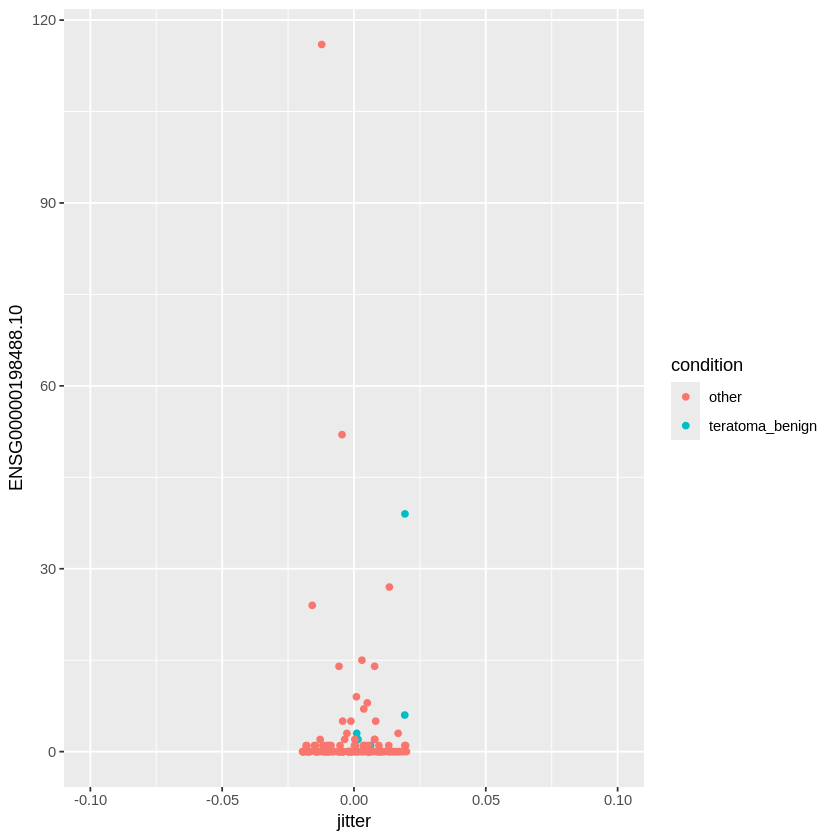

In [292]:
ggplot(transposed_raw_counts) +
     geom_point(aes(x= jitter, y = ENSG00000198488.10, color = condition)) + xlim(-0.1, 0.1)

Diferencialinė analizė

In [277]:
# Create DESeqDataSet object from count matrix and sample information
dds <- DESeqDataSetFromMatrix(countData = raw_counts, colData = col_data, design = ~ condition)


In [278]:
# Run DESeq2 analysis
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1043 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [279]:
# Get results (comparison of 'control' vs. 'treatment')
res <- results(dds)

# View results
head(res, n = 10)


log2 fold change (MLE): condition teratoma benign vs other 
Wald test p-value: condition teratoma benign vs other 
DataFrame with 10 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003.15 3930.2223     -0.4314724  0.260234 -1.658015 9.73144e-02
ENSG00000000005.6    52.1511      4.8387346  0.900671  5.372368 7.77094e-08
ENSG00000000419.13 1657.0442     -0.4377217  0.252607 -1.732814 8.31287e-02
ENSG00000000457.14  582.5080      0.3626797  0.206010  1.760494 7.83241e-02
ENSG00000000460.17  727.9203     -0.8629980  0.298831 -2.887914 3.87806e-03
ENSG00000000938.13 1248.1954     -2.2699972  0.670952 -3.383248 7.16340e-04
ENSG00000000971.16 1484.1912      1.3026437  0.519193  2.508980 1.21080e-02
ENSG00000001036.14 1315.9234      0.2225644  0.365347  0.609186 5.42401e-01
ENSG00000001084.13 1297.9924      0.2411315  0.218473  1.103715 2.69717e-01
ENSG00000001

In [280]:
summary(res)


out of 18490 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4133, 22%
LFC < 0 (down)     : 5206, 28%
outliers [1]       : 228, 1.2%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [281]:
ordering <- order(res$padj, decreasing = FALSE)
res <- res[ordering,]
head(res)

log2 fold change (MLE): condition teratoma benign vs other 
Wald test p-value: condition teratoma benign vs other 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000075073.15   33.4595        5.98183  0.452297   13.2255 6.25586e-40
ENSG00000167676.4   214.9257        5.06627  0.386299   13.1149 2.70485e-39
ENSG00000181856.15  163.3900        4.04582  0.308832   13.1004 3.27523e-39
ENSG00000077157.22 2445.4345        4.21261  0.336196   12.5302 5.10132e-36
ENSG00000172403.11 1265.5652        5.11979  0.411363   12.4459 1.47162e-35
ENSG00000130176.8  1760.3863        5.77666  0.532393   10.8504 1.98623e-27
                          padj
                     <numeric>
ENSG00000075073.15 1.14244e-35
ENSG00000167676.4  1.99374e-35
ENSG00000181856.15 1.99374e-35
ENSG00000077157.22 2.32901e-32
ENSG00000172403.11 5.37493e-32
ENSG00000130176.8  6.045

In [291]:
top_gene_ids <- row.names(res)[1:100]
top_gene_ids
#top_genes <- gene_expression_counts[gene_expression_counts$gene_id %in% top_gene_ids, c('gene_id', 'gene_name')]
top_genes <- gene_expression_counts[ordering, c('gene_id', 'gene_name')]
top_genes$padj <- res$padj
top_genes

[1] "ENSG00000075073.15" "ENSG00000167676.4"  "ENSG00000181856.15"
  [4] "ENSG00000077157.22" "ENSG00000172403.11" "ENSG00000130176.8" 
  [7] "ENSG00000065534.19" "ENSG00000197361.8"  "ENSG00000162614.19"
 [10] "ENSG00000182253.15" "ENSG00000101115.13" "ENSG00000137948.18"
 [13] "ENSG00000091436.17" "ENSG00000095637.22" "ENSG00000148200.17"
 [16] "ENSG00000183963.19" "ENSG00000121577.14" "ENSG00000156804.7" 
 [19] "ENSG00000133392.18" "ENSG00000134323.12" "ENSG00000163431.13"
 [22] "ENSG00000035403.18" "ENSG00000149591.17" "ENSG00000058668.15"
 [25] "ENSG00000072163.20" "ENSG00000167634.12" "ENSG00000140416.23"
 [28] "ENSG00000101057.16" "ENSG00000170627.11" "ENSG00000131142.13"
 [31] "ENSG00000159176.14" "ENSG00000145012.13" "ENSG00000107796.13"
 [34] "ENSG00000136872.20" "ENSG00000145936.9"  "ENSG00000283567.1" 
 [37] "ENSG00000135355.4"  "ENSG00000152642.11" "ENSG00000213889.10"
 [40] "ENSG00000077152.11" "ENSG00000100490.9"  "ENSG00000168497.5" 
 [43] "ENSG00000285868.1"  "ENSG00000095303.17" "ENSG00000154678.18"
 [46] "ENSG00000135842.17" "ENSG00000162551.14" "ENSG00000157551.19"
 [49] "ENSG00000163820.15" "ENSG00000105641.4"  "ENSG00000162433.15"
 [52] "ENSG00000174099.12" "ENSG00000139351.15" "ENSG00000101335.10"
 [55] "ENSG00000163286.9"  "ENSG00000112273.7"  "ENSG00000050344.9" 
 [58] "ENSG00000111704.11" "ENSG00000115163.15" "ENSG00000181026.15"
 [61] "ENSG00000180432.6"  "ENSG00000183696.14" "ENSG00000079308.19"
 [64] "ENSG00000108106.14" "ENSG00000102021.11" "ENSG00000164045.12"
 [67] "ENSG00000130208.9"  "ENSG00000198467.16" "ENSG00000258405.11"
 [70] "ENSG00000154839.10" "ENSG00000151650.8"  "ENSG00000102096.9" 
 [73] "ENSG00000196924.19" "ENSG00000175832.13" "ENSG00000058272.19"
 [76] "ENSG00000176979.14" "ENSG00000169548.3"  "ENSG00000164744.13"
 [79] "ENSG00000131471.7"  "ENSG00000129116.19" "ENSG00000183765.23"
 [82] "ENSG00000177398.18" "ENSG00000119938.9"  "ENSG00000214107.8" 
 [85] "ENSG00000159055.4"  "ENSG00000082196.21" "ENSG00000140682.19"
 [88] "ENSG00000146839.19" "ENSG00000130203.10" "ENSG00000158683.9" 
 [91] "ENSG00000170684.9"  "ENSG00000141255.13" "ENSG00000127423.11"
 [94] "ENSG00000105141.6"  "ENSG00000163297.17" "ENSG00000111540.16"
 [97] "ENSG00000146670.10" "ENSG00000174282.12" "ENSG00000178445.10"
[100] "ENSG00000122786.20"

,gene_id,gene_name,padj
,<chr>,<chr>,<dbl>
ENSG00000075073.15,ENSG00000075073.15,TACR2,1.142444e-35
ENSG00000167676.4,ENSG00000167676.4,PLIN4,1.993739e-35
ENSG00000181856.15,ENSG00000181856.15,SLC2A4,1.993739e-35
ENSG00000077157.22,ENSG00000077157.22,PPP1R12B,2.329008e-32
ENSG00000172403.11,ENSG00000172403.11,SYNPO2,5.374929e-32
ENSG00000130176.8,ENSG00000130176.8,CNN1,6.045421e-24
ENSG00000065534.19,ENSG00000065534.19,MYLK,5.457569e-22
ENSG00000197361.8,ENSG00000197361.8,FBXL22,5.947898e-22
ENSG00000162614.19,ENSG00000162614.19,NEXN,7.938739e-22


In [283]:
'SALL4' %in% top_genes$gene_name

[1] TRUE

In [284]:
top_genes$gene_name

[1] "TACR2"      "PLIN4"      "SLC2A4"     "PPP1R12B"   "SYNPO2"    
   [6] "CNN1"       "MYLK"       "FBXL22"     "NEXN"       "SYNM"      
  [11] "SALL4"      "BRDT"       "MAP3K20"    "SORBS1"     "NR6A1"     
  [16] "SMTN"       "POPDC2"     "FBXO32"     "MYH11"      "MYCN"      
  [21] "LMOD1"      "VCL"        "TAGLN"      "ATP2B4"     "LIMS2"     
  [26] "NLRP7"      "TPM1"       "MYBL2"      "GTSF1"      "CCL25"     
  [31] "CSRP1"      "LPP"        "ACTA2"      "ALDOB"      "KCNMB1"    
  [36] "C19orf85"   "GJA10"      "GPD1L"      "PPM1N"      "UBE2T"     
  [41] "CDKL1"      "CAVIN2"     "AC008676.3" "PTGS1"      "PDE1C"     
  [46] "NIBAN1"     "ALPL"       "KCNJ15"     "FYCO1"      "SLC5A5"    
  [51] "AK4"        "MSRB3"      "SYCP3"      "MYL9"       "ALPG"      
  [56] "HDGFL1"     "NFE2L3"     "NANOG"      "CENPA"      "AEN"       
  [61] "CYP8B1"     "UPP1"       "TNS1"       "UBE2S"      "LUZP4"     
  [66] "CDC25A"     "APOC1"      "TPM2"       "ZNF578"     "SKA1"      
  [71] "VENTX"      "PIM2"       "FLNA"       "ETV4"       "PPP1R12A"  
  [76] "TRIM60"     "ZNF280A"    "SUN3"       "AOC3"       "PALLD"     
  [81] "CHEK2"      "UMODL1"     "PPP1R3C"    "MAGEB1"     "MIS18A"    
  [86] "C1QTNF3"    "TGFB1I1"    "ZAN"        "APOE"       "PKD1L1"    
  [91] "ZNF296"     "SPATA22"    "AUNIP"      "CASP14"     "ANTXR2"    
  [96] "RAB5B"      "CDCA5"      "ZBTB4"      "GLDC"       "CALD1"     
 [101] "NANOGP8"    "HCN2"       "POLR1G"     "ACSM2A"     "ERCC6L"    
 [106] "KLRG2"      "SPEG"       "TENT5B"     "DES"        "SYNGR3"    
 [111] "WDR62"      "AIRE"       "NLRP2"      "CPAMD8"     "L1TD1"     
 [116] "FRAT2"      "TSTD3"      "HIC2"       "TBPL2"      "ZYG11A"    
 [121] "ARHGEF25"   "TOMM40"     "RASL12"     "FOXR1"      "ZNF587B"   
 [126] "HORMAD1"    "FHL1"       "PSD"        "AEBP1"      "PRKCA"     
 [131] "RAB15"      "CDC42EP3"   "NLRP9"      "ALPP"       "SLC25A33"  
 [136] "SPOP"       "ZNF101"     "ABCC12"     "ERVW-1"     "SUSD2"     
 [141] "LIM2"       "CASZ1"      "KANK2"      "PCED1B"     "BSND"      
 [146] "EPOP"       "TEAD4"      "PLXNA4"     "CYP2S1"     "PDCL2"     
 [151] "TNNI3"      "OIP5"       "FANCD2"     "PSORS1C2"   "MYOM1"     
 [156] "TSPAN2"     "SH2B2"      "POLRMT"     "UNG"        "PDCD2L"    
 [161] "RRP9"       "TULP2"      "OR7E24"     "MAP4K1"     "EXOSC5"    
 [166] "ADD1"       "NFE2"       "TCL1B"      "ATF7"       "SSC5D"     
 [171] "POU5F1"     "SOWAHD"     "BEND3"      "ANKRD55"    "PANX3"     
 [176] "MSH2"       "KCND3"      "DLGAP3"     "ZNF682"     "RNF17"     
 [181] "PRSS41"     "MFAP5"      "TACC1"      "SRSF2"      "AC005833.1"
 [186] "RBMXL2"     "BCL2L12"    "CALCOCO1"   "WDHD1"      "RAD51"     
 [191] "PLN"        "PRKAG2"     "GREM1"      "NCR1"       "RNF125"    
 [196] "JPH2"       "FAM71F1"    "THRA"       "ITIH5"      "RGS2"      
 [201] "MYOCD"      "GNG12"      "RASGEF1A"   "CCT8"       "HSPB7"     
 [206] "PPM1G"      "MAGEB2"     "ABCB1"      "ARID3B"     "VRTN"      
 [211] "PTPRQ"      "TRIM28"     "LPAR2"      "KCNAB1"     "IL6"       
 [216] "ORC6"       "TRIM71"     "YRDC"       "TINAGL1"    "ACTG2"     
 [221] "NOP56"      "ZNF681"     "CPNE6"      "CHRNB3"     "DBF4"      
 [226] "SPDYC"      "BFSP2"      "MBD5"       "UTF1"       "SLC2A14"   
 [231] "DLL3"       "FEN1"       "MPV17L2"    "CARMIL2"    "PDLIM7"    
 [236] "RNF138"     "HELLS"      "KASH5"      "RRP12"      "DDX43"     
 [241] "ZNF93"      "HJURP"      "PRR20G"     "NACC1"      "EZHIP"     
 [246] "ZNF215"     "C19orf84"   "CCT6A"      "SLC5A6"     "PLCL1"     
 [251] "RABGAP1"    "THSD4"      "ATIC"       "SPZ1"       "NUDT1"     
 [256] "DCAF4L2"    "EEF2K"      "MMP15"      "RMND1"      "CHEK1"     
 [261] "DPPA5"      "PYGM"       "SLC8A1"     "RHCG"       "MIIP"      
 [266] "PRAME"      "NLRP12"     "PDE5A"      "NGEF"       "CKS2"      
 [271] "CFL2"       "RAB3B"      "KPNA2"      "OOEP"       "PSMG1"     
 [276] "TBRG4"      "CLEC4D"     "RESF1"   

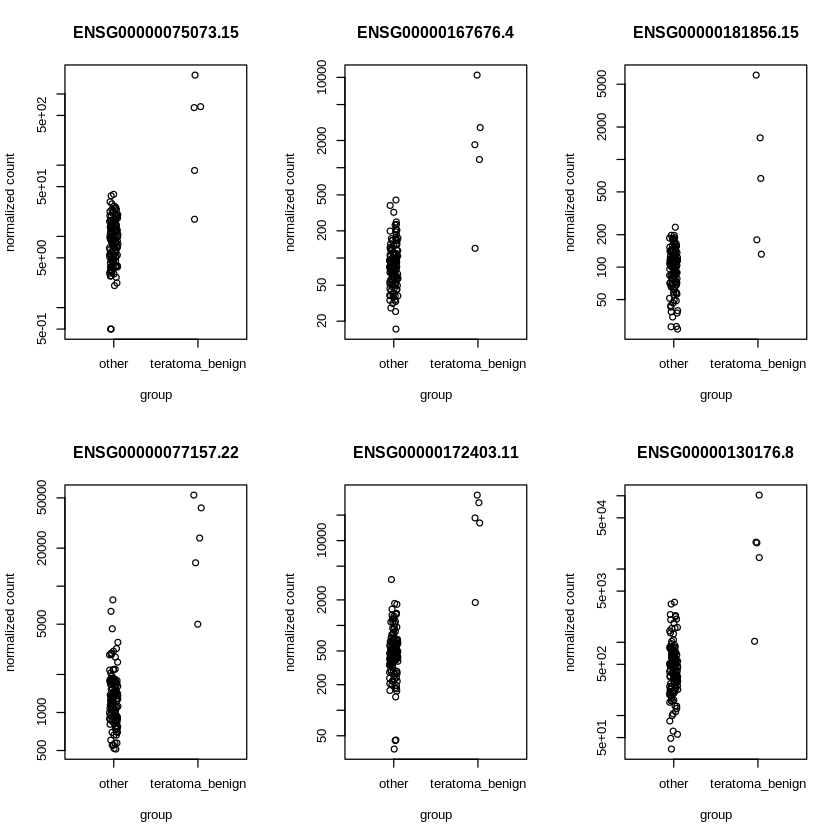

In [285]:
par(mfrow=c(2,3))

plotCounts(dds, gene="ENSG00000075073.15", intgroup="condition")
plotCounts(dds, gene="ENSG00000167676.4", intgroup="condition")
plotCounts(dds, gene="ENSG00000181856.15", intgroup="condition")
plotCounts(dds, gene="ENSG00000077157.22", intgroup="condition")
plotCounts(dds, gene="ENSG00000172403.11", intgroup="condition")
plotCounts(dds, gene="ENSG00000130176.8", intgroup="condition")

using ntop=500 top features by variance



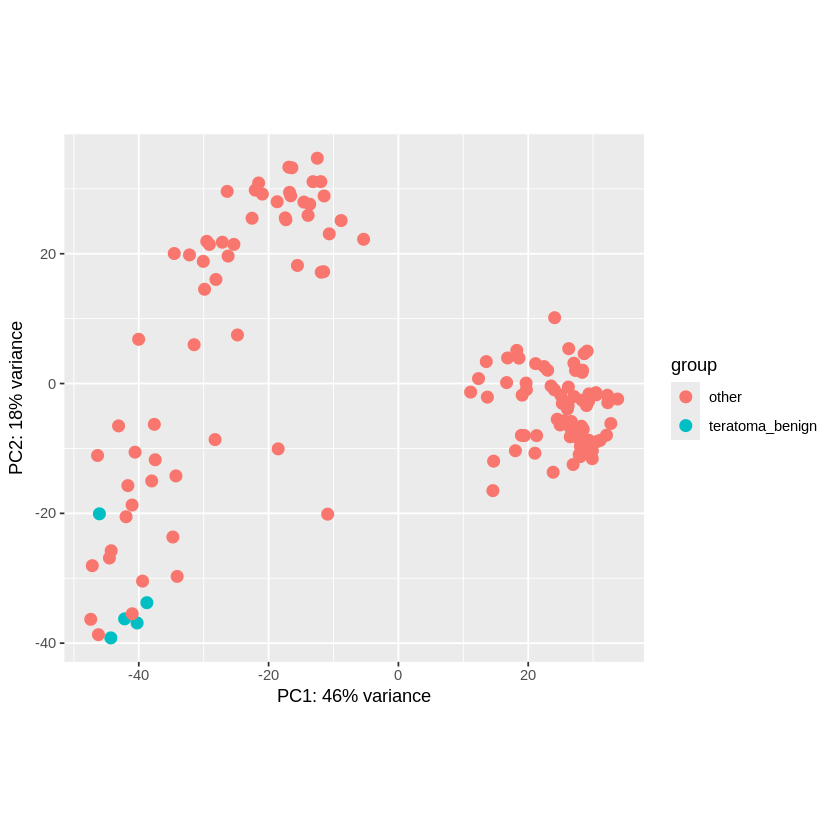

In [286]:
vsdata <- vst(dds, blind=FALSE)
plotPCA(vsdata, intgroup="condition") #using the DESEQ2 plotPCA fxn we can

In [293]:
write.csv(top_genes,"all_ordered_genes.csv", row.names = FALSE)